<a href="https://colab.research.google.com/github/surabhipandey18/Deep-Learning/blob/main/resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

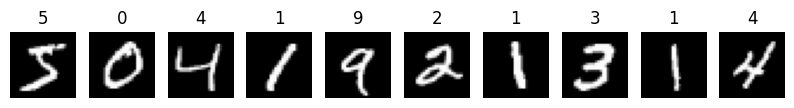

In [ ]:
#see the images first 10
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")
plt.show()

In [ ]:
#let's create the model
def resnet_block(x, filters, stride=1, weight_decay=0.0):
  shortcut = x
  x = layers.Conv2D(filters, 3, strides = stride, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  if stride != 1 or shortcut.shape[-1] != filters:
    shortcut = layers.Conv2D(filters, 1, strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

def resnet(input_shape=(28, 28, 1), num_classes=10, weight_decay=0.0):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = resnet_block(x, 32, 1, weight_decay)
  x = resnet_block(x, 32, 1, weight_decay)

  x = resnet_block(x, 64, 2, weight_decay)
  x = resnet_block(x, 64, 1, weight_decay)

  x = resnet_block(x, 128, 2, weight_decay)
  x = resnet_block(x, 128, 1, weight_decay)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x) # Added this line

  model = models.Model(inputs, outputs) # Changed x to outputs
  return model

optimizers = [('Adam', Adam(learning_rate=1e-3)),('AdamW', AdamW(weight_decay=1e-4, learning_rate=1e-3))]
histories={}

In [ ]:
for opt_name, optimizer in optimizers:
    print(f"\nTraining with {opt_name} optimizer.")
    model = resnet(weight_decay=1e-4 if opt_name == 'AdamW' else 0.0)
    plot_model(model, to_file=f'{opt_name}_model_architecture.png', show_shapes=True, show_layer_names=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    with tf.device('/GPU:0'):
        history = model.fit(
            x_train, y_train,
            epochs=5,
            batch_size=128,
            validation_data=(x_test, y_test)
        )
    histories[opt_name] = history


Training with Adam optimizer.
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8987 - loss: 0.3459 - val_accuracy: 0.9210 - val_loss: 0.2563
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9887 - loss: 0.0375 - val_accuracy: 0.9668 - val_loss: 0.1046
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9905 - loss: 0.0293 - val_accuracy: 0.9466 - val_loss: 0.1760
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9928 - loss: 0.0229 - val_accuracy: 0.9857 - val_loss: 0.0466
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9933 - loss: 0.0205 - val_accuracy: 0.9829 - val_loss: 0.0563

Training with AdamW optimizer.
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9008 - loss: 0.4271 - val_accuracy: 0.9608 - val_loss: 0.2117
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9878 - loss: 0.1249 - val_accuracy: 0.9555 - val_loss: 0.2176
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━

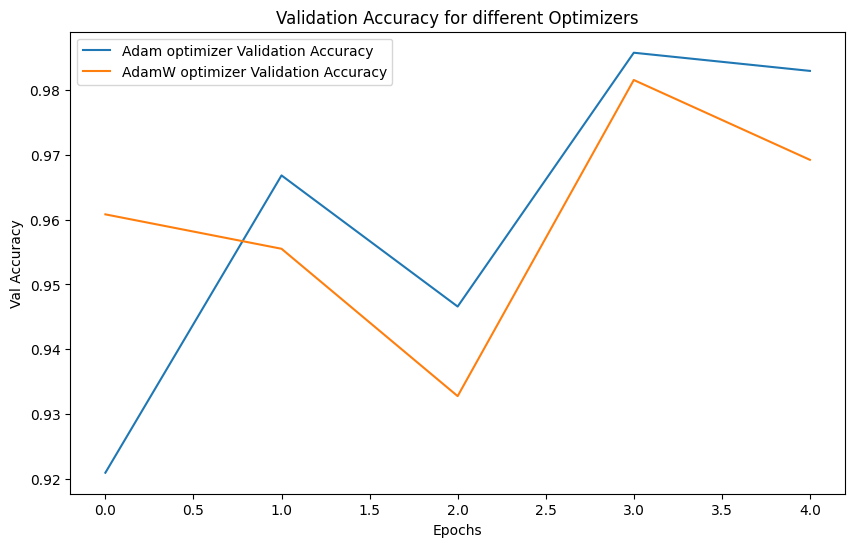

In [ ]:
#figure of different optimizers working
plt.figure(figsize=(10, 6))
for opt_name, optimizer in optimizers:
    plt.plot(histories[opt_name].history['val_accuracy'], label=f"{opt_name} optimizer Validation Accuracy")
plt.title("Validation Accuracy for different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

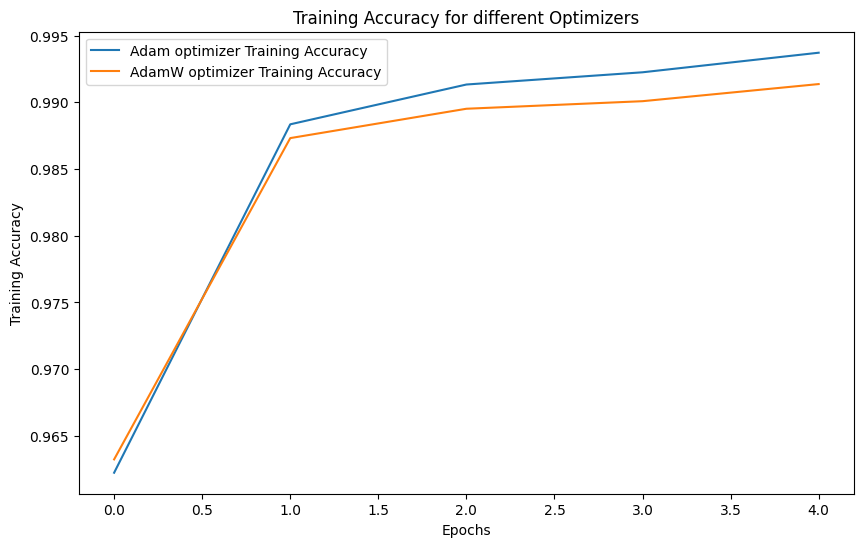

In [ ]:
#figure of training accuracy
plt.figure(figsize=(10, 6))
for opt_name, optimizer in optimizers:
    plt.plot(histories[opt_name].history['accuracy'], label=f"{opt_name} optimizer Training Accuracy")
plt.title("Training Accuracy for different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

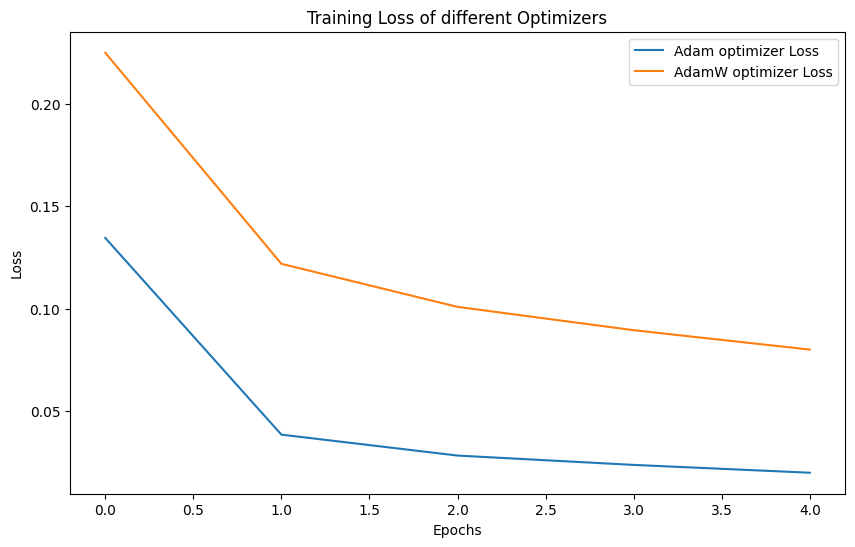

In [ ]:
#figure of different loss of optimizers
plt.figure(figsize=(10, 6))
for opt_name,optimizer in optimizers:
    plt.plot(histories[opt_name].history['loss'], label=f"{opt_name} optimizer Loss")
plt.title("Training Loss of different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

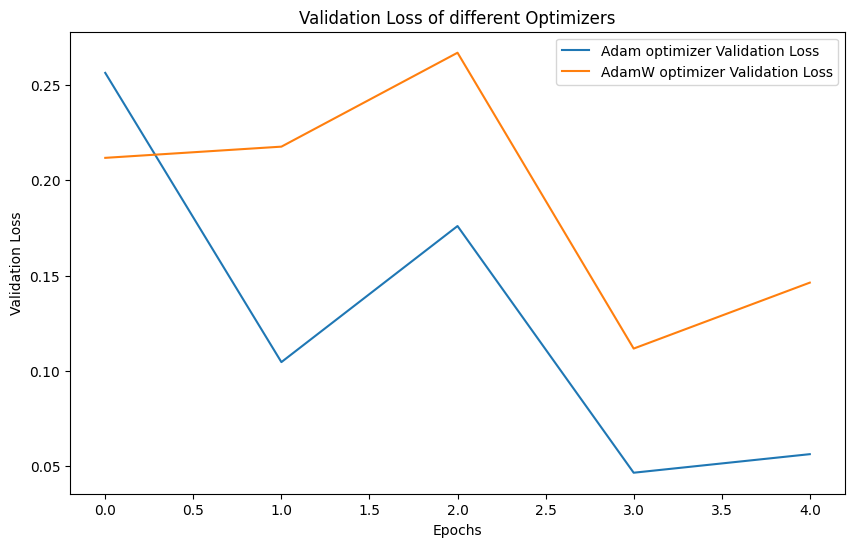

In [ ]:
#figure of different loss of optimizers (validation)
plt.figure(figsize=(10, 6))
for opt_name,optimizer in optimizers:
    plt.plot(histories[opt_name].history['val_loss'], label=f"{opt_name} optimizer Validation Loss")
plt.title("Validation Loss of different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [ ]:
#tabulating all
for opt_name,optimizer in optimizers:
    val_accuracy = histories[opt_name].history['val_accuracy'][-1]
    loss = histories[opt_name].history['loss'][-1]
    print(f"{opt_name} → Val Accuracy: {val_accuracy:.4f}, Val Loss: {loss:.4f}")

Adam → Val Accuracy: 0.9829, Val Loss: 0.0200
AdamW → Val Accuracy: 0.9692, Val Loss: 0.0801


In [ ]:
import pickle

with open('alexnet_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
